### 05/22/23 - This notebook is copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/kinematics_maps/plot_kinematics_contours/plot_kinematics_contours_V_VD_bspline_models_margin_gnog_050823.ipynb
#### See https://docs.google.com/spreadsheets/d/141wpCILejD7JhJdo5OuwJAY6xN7B-lNpK36Gbvr8o4k/edit#gid=1171125292&range=B478
#### I should have set the photometry up to convert to B-band instead of I-band for F435W
### 05/30/23 - Updating to do the other objects besides J0037... starting with J1621
### 05/31/23 - Updating correct photometry practices... See emails with Tommaso. 
https://mail.google.com/mail/u/0/?tab=rm&ogbl#inbox/QgrcJHsHpClsHsxLMLKBvnrXbjRmTmwFDTQ
### 06/01/23 - Cleaning up for ease of use.
# 06/05/23 - J1112

In [6]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import plot_contours_531
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import plot_kinematics_mge_contours
from slacs_mge_jampy import get_bin_centers
from slacs_mge_jampy import jampy_details

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC


In [7]:
# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2023-02-28_2'

###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################


Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2023-02-28_2/



In [8]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff
        
def get_bins (file_dir, obj_name):
    
    scale=0.1457
    
    #######################################
    ## import voronoi binning data
    voronoi_binning_data = fits.getdata(file_dir +'voronoi_binning_' + obj_name + '_data.fits')
    vorbin_pixels = np.genfromtxt(f'{file_dir}voronoi_2d_binning_{obj_name}_output.txt',
                     delimiter='')
    # sort the voronoi bin pixel data by bin
    vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]
    
    ########################################
    # find bin centers
    xbin, ybin = get_bin_centers (vorbin_pixels, len(voronoi_binning_data))
    
     #######################################
    # Changes - 11/30/22
    #######################################

    # convert to arcsec # kcwi!
    xbin_arcsec = xbin * scale
    ybin_arcsec = ybin * scale

    return xbin_arcsec, ybin_arcsec

In [9]:
obj_names[3]

'SDSSJ1112+0826'

# Load images

In [10]:
obj_names_index=3
obj_name = obj_names[obj_names_index]

print('#####################################################################################################################')
print('#####################################################################################################################')
print()
print(f'Beginning final kinematics visualization and plotting for object {obj_name}.')
print()

obj_abbr = obj_name[4:9] # e.g. J0029

    #------------------------------------------------------------------------------
# object-specific directories

mos_dir = f'{mosaics_dir}{obj_name}/' 
kin_dir = f'{kinematics_dir}{obj_name}/'

print('################################################')
print('Getting KCWI datacube')

kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y, kcwi_pa = import_center_crop(data_dir, mos_dir, obj_name, obj_names_index, obj_abbr, 
                                                                          data_source='kcwi_datacube', plot=False)


hst_full_img, hst_5arc_img, hst_3arc_img, bspl_full_img, bspl_5arc_img, bspl_3arc_img, hst_header, \
    central_pix_x, central_pix_y, exp_time, bspl_PA = import_center_crop(data_dir, hst_dir, obj_name, obj_names_index, obj_abbr, 
                                                      data_source='HST', plot=False)

#####################################################################################################################
#####################################################################################################################

Beginning final kinematics visualization and plotting for object SDSSJ1112+0826.

################################################
Getting KCWI datacube


In [7]:
hst_header['EXPTIME']

420.0

In [8]:
hst_header['TOT_TIME']

420.0

In [9]:
hst_header['DATE-OBS']

'2006-02-28'

In [10]:
hst_header['Filter2']

'F814W'

In [11]:
#Results for 2006-02-28
#Detector	Filter	PHOTLAM [Å]	PHOTFLAM [erg cm⁻² Å⁻¹ e⁻¹]	STmag	VEGAmag	ABmag
#WFC	F814W	8047.9	7.0153e-20	26.785	25.517	25.948

# Bring in pickle for light profile, auxiliary data

In [23]:
file_m = glob.glob(f'{mos_dir}{obj_name}_mge_fit_sectors_regularized_model.pkl')
if file_m:
    print('mge model exists, loading...')
    with open(file_m[0], 'rb') as file:
        m = pickle.load(file)

    print('################################################')
    print('Regularized MGE fit')
    
# get the model surface brightness profiles
# convert sigma from pixels to arcsec
sigma_pix = m.sol[1]
sigma = sigma_pix * hst_scale
# q 
q = m.sol[2]
# surface brightness
total_counts = m.sol[0]    

# bring in the paper table for 
paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')

# start with J0037
#obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
#obj_abbr = obj_name[4:9] # e.g. J0029
zlens = paper_table[paper_table['obj_name']==obj_name]['zlens'].to_numpy()[0] #zs[1]
ang_distance = cosmo.angular_diameter_distance(zlens).value
lum_distance = cosmo.luminosity_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
#jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
#Path(jam_dir).mkdir(parents=True, exist_ok=True)


mge model exists, loading...
################################################
Regularized MGE fit


# Load tables from SLACS IX

In [13]:
tab3 = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
tab4 = pd.read_table(f'{tables_dir}slacs_ix_table4.txt')

In [16]:
# Load conversions from Treu05

conversions = pd.read_table(f'{tables_dir}treu05_restframe_conversions.txt')

In [17]:
conversions

,N,alpha_Bvbv,beta_Bvbv,alpha_Bivi,beta_Bivi,alpha_Bziz,beta_Bziz alpha_Vvbv,beta_Vvbv,alpha_Vivi,beta_Vivi,alpha_Vziz,beta_Vziz
0,0,0.824411,-0.00169895,2.44316,0.748236,1491.01,-796.805 0.186741,-0.0274962,1.42588,-0.0394309,-77.0651,46.5707
1,1,-3.29360,1.22223,-4.42301,-3.72483,-8947.85,4776.19-2.62562,0.995802,-5.13394,1.23626,668.5810,-399.7670
2,2,3.40645,-8.36258,1.53361,7.43317,22264.20,-11813.0 7.19822,0.0925006,4.22521,-1.42416,-2294.2100,1398.8500
3,3,Nan,18.9313,Nan,-3.58153,-29340.50,15426.2 Nan,Nan,Nan,1.88833,4056.1900,-2539.3100
4,4,Nan,Nan,Nan,Nan,21564.40,-11200.7 Nan,Nan,Nan,Nan,-3936.6700,2531.9600
5,5,Nan,Nan,Nan,Nan,-8367.60,4278.26 Nan,Nan,Nan,Nan,1999.8600,-1319.0100
6,6,Nan,Nan,Nan,Nan,1336.45,-669.418 Nan,Nan,Nan,Nan,-417.4320,281.5890


# Photometry corrections to get close.
# Since filter is F814W, we need Bivi

In [18]:
# calculate restrfame correction from DM and redshift
r = lum_distance * 10**6 # distance in pc
DM = 5 * np.log10(r/10)
# slacs ix values
B9 = float(tab4[tab4['Name']==obj_name]['M_B'].values[0][:6]) #-22.37
#b9 = float(tab3[tab3['Name']==obj_name]['m_B'].values[0]) #18.57 # B band app mag
i9 = float(tab3[tab3['Name']==obj_name]['m_I'].values[0]) #18.57 # B band app mag
v9 = float(tab3[tab3['Name']==obj_name]['m_V'].values[0]) # 16.9 # V band app mag

# alpha and beta are functions of redshift (from https://iopscience.iop.org/article/10.1086/444585/fulltext/)
alpha_conversions = conversions['alpha_Bivi'].astype(float)
a0 = alpha_conversions.iloc[0]
a1 = alpha_conversions.iloc[1]
a2 = alpha_conversions.iloc[2]
alpha = a0 + a1 * zlens /  + a2 * zlens**2   # alpha coeffi
beta_conversions = conversions['beta_Bivi'].astype(float)
b0 = beta_conversions.iloc[0]
b1 = beta_conversions.iloc[1]
b2 = beta_conversions.iloc[2]
b3 = beta_conversions.iloc[3]
beta = b0 + b1 * zlens + b2 * zlens**2 + b3 * zlens**3 # coeff 
# final calculation
#restframe_correction = (1 - alpha) * (v9 - b9) + beta - DM
restframe_correction = alpha * (v9 - i9) + beta - DM

# photometry corrections and zeropoint
#Results for 2006-02-28
#Detector	Filter	PHOTLAM [Å]	PHOTFLAM [erg cm⁻² Å⁻¹ e⁻¹]	STmag	VEGAmag	ABmag
#WFC	F814W	8047.9	7.0153e-20	26.785	25.517	25.948
zeropoint = 25.948 #
inf_ap_correction = 0.1
extinctions = pd.read_csv(f'{data_dir}tables/slacs_extinctions.csv')
#extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_B'].values[0]
extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_I'].values[0]

In [19]:


# counts of Gaussians to apparent magnitude
B_app_mag = - 2.5 * np.log10(total_counts/exp_time) + zeropoint + inf_ap_correction - extinction

# correct to restframe
B_abs_mag = B_app_mag + restframe_correction

# convert to surface magnitudes
B_surf_mag = B_abs_mag + 2.5 * np.log10(2*np.pi*q*sigma_pix**2*hst_scale**2)

# convert to surface brightness in L_sol_B / pc^2
#M_sol_I = 4.08
M_sol_B = 5.45
B_surf_br_arcsec = 10**( 0.4 * (M_sol_B - B_surf_mag)) # L_sol_B / arcsec^2
B_surf_br_pc = B_surf_br_arcsec * (206265/(ang_distance*10**6))**2

# calculate total magnitude for fudge factor to scale to slacs ix value
total_appmag_B = zeropoint + inf_ap_correction + 2.5 * np.log10(exp_time) \
                            - 2.5 * np.log10(np.sum(total_counts)) - extinction
total_magnitude_B = total_appmag_B + restframe_correction 
log_fudge_factor = total_magnitude_B - B9
fudged_surface_brightness = B_surf_br_pc * 10**(0.4 * log_fudge_factor)

fudged_surface_brightness



array([5.64990570e+04, 8.41785888e+03, 2.29096661e+03, 2.64250471e+03,
       7.49183312e+02, 4.12012989e+02, 1.38820892e+02, 1.87978984e+01])

In [20]:
log_fudge_factor

1.010681571765975

# Replace the surface brightness in "details_for_jampy.pkl" for all SN schemes

In [21]:
for SN in vorbin_SN_targets:
    target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    #target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    #Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # take the surface density, etc from mge saved parameters
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)


    tommy_pickles.surf_density = fudged_surface_brightness
    
    # dump the pickle back in
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'wb') as f:
        pickle.dump(tommy_pickles, f)

# Look at the orientation

In [11]:
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)


surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff


axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]


xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)


In [14]:
Vrms_bin

array([285.83824313, 278.22441238, 274.16922079, 280.15162414,
       280.72930632, 271.2598662 , 281.22817525, 262.22176598,
       250.04515961, 235.67373058, 251.80526285, 274.83157244,
       270.87680921, 289.60235788, 266.87053688, 270.66760459,
       272.84648715, 277.62346812, 226.69318578, 281.32950321,
       269.80839541, 267.52386664, 277.0985534 , 265.15758627,
       245.65400804, 274.77817058, 267.52893539, 263.24708302,
       271.53907866, 269.50263796, 265.1836555 ,  11.07579677,
       227.79447715,  11.07579677])

In [15]:
goodbins = Vrms_bin > 50

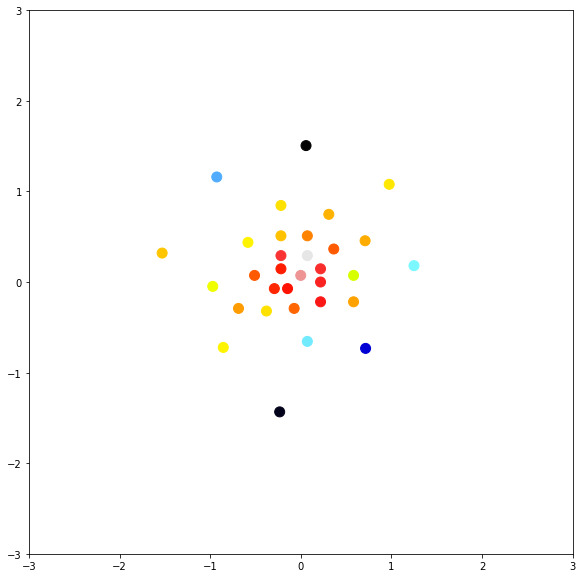

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_arcsec[goodbins], ybin_arcsec[goodbins], s=100, c=Vrms_bin[goodbins], cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

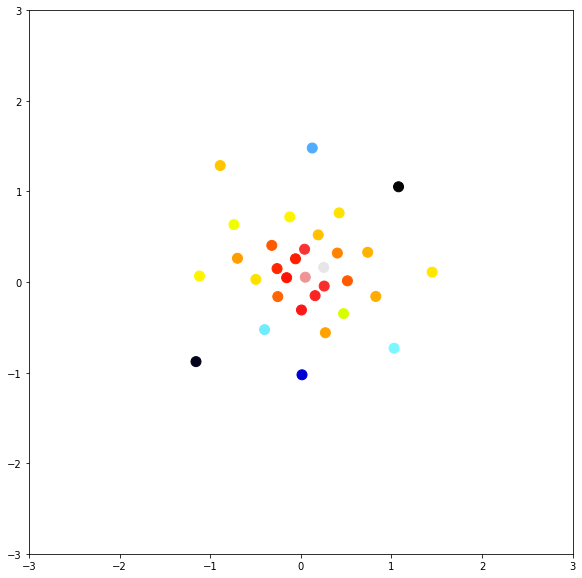

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_phot[goodbins], ybin_phot[goodbins], s=100, c=Vrms_bin[goodbins], cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

# See if it rotates properly with KCWI PA and PA_phot

In [18]:
xbin_phot_rot, ybin_phot_rot = rotate_points(xbin_arcsec, ybin_arcsec, kcwi_pa-90-pa_phot)

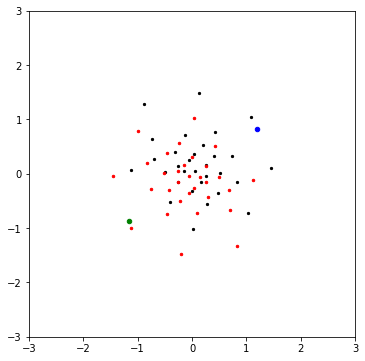

In [19]:
fig, axs = plt.subplots(1, figsize=(8,6))
axs.scatter(xbin_phot[goodbins], ybin_phot[goodbins],s=5,c='k',)
axs.scatter(xbin_phot_rot[goodbins], ybin_phot_rot[goodbins], s=6, c='r')
axs.scatter(xbin_phot[goodbins][-1], ybin_phot[goodbins][-1],s=20,c='g',)
axs.scatter(xbin_phot_rot[goodbins][-1], ybin_phot_rot[goodbins][-1], s=20, c='b')
axs.set_xlim(-3,3)
axs.set_ylim(-3,3)
axs.set_aspect('equal')

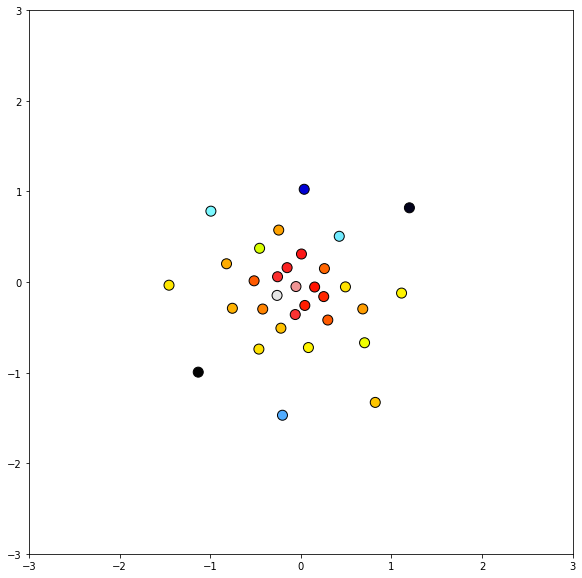

In [20]:

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_phot_rot[goodbins], ybin_phot_rot[goodbins], s=100, edgecolor='k', c=Vrms_bin[goodbins], cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

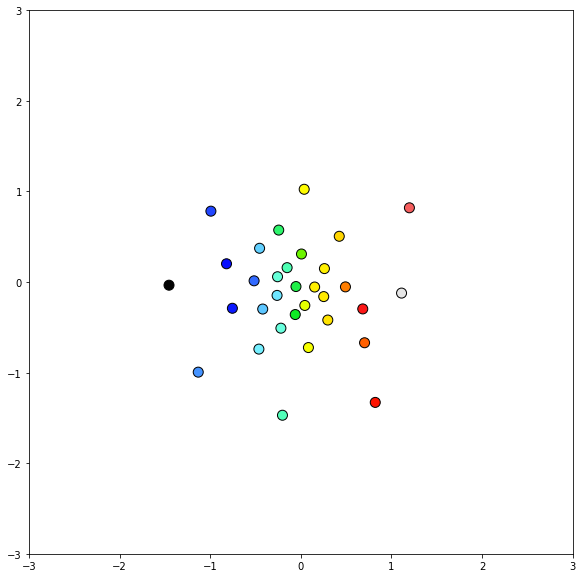

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_phot_rot[goodbins], ybin_phot_rot[goodbins], s=100, edgecolor='k', c=V_bin[goodbins], cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

# Check the JAM model

####################################################
####################################################
Rotated by pa_phot


/home/shawnknabel/.local/lib/python3.7/site-packages/jampy/jam_axi_proj.py:844: RuntimeWarning: divide by zero encountered in true_divide
  d, m = (data/errors)[goodbins], (model/errors)[goodbins]
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 7.44
inc=75.0; beta[1]=0.20; kappa=2.07; M/L=1.00; BH=0.0; chi2/DOF=4.87
Total mass MGE (MSun): 1.202e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


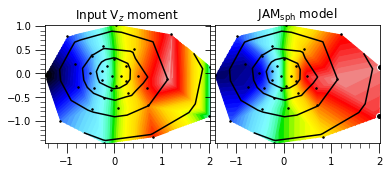

jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 6.23
inc=75.0; beta[1]=0.20; kappa=1.00; M/L=4.71; BH=0.0; chi2/DOF=0.00821
Total mass MGE (MSun): 5.658e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


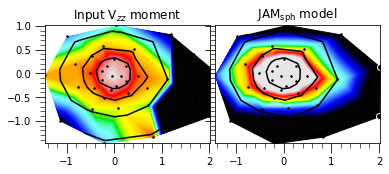

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [43]:
pixsize=kcwi_scale
beta=np.ones_like(surf)*0.2
sigmapsf=kcwi_sigmapsf,
#goodbins=None
inc=75
mbh=0
distance=cosmo.angular_diameter_distance(zlens).value


print('####################################################')
print('####################################################')
print(f'Rotated by pa_phot')

moment = 'z'
data = V_bin
errors = dV_bin

# The model is by design similar but not identical to the adopted kinematics!
jam_axi_proj(surf, sigma, qObs, surf, sigma, qObs,
                 inc, mbh, distance, xbin_phot_rot, ybin_phot_rot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=False)
plt.pause(3)
plt.figure(2)

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

# The model is by design similar but not identical to the adopted kinematics!
jam_axi_proj(surf, sigma, qObs, surf, sigma, qObs,
                 inc, mbh, distance, xbin_phot_rot, ybin_phot_rot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=False)
plt.pause(3)
plt.figure(2)


# I'm not sure why JAM didn't recognize my goodbins mask.

####################################################
####################################################
Rotated by pa_phot
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 5.39
inc=75.0; beta[1]=0.20; kappa=2.07; M/L=1.00; BH=0.0; chi2/DOF=4.87
Total mass MGE (MSun): 1.202e+11


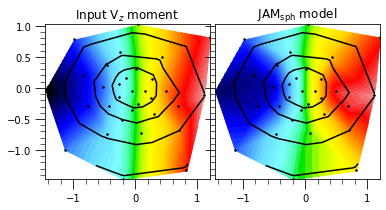

jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 7.21
inc=75.0; beta[1]=0.20; kappa=1.00; M/L=4.71; BH=0.0; chi2/DOF=0.00821
Total mass MGE (MSun): 5.659e+11


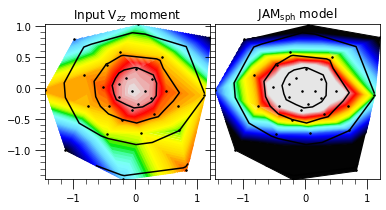

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
# Remove the masked bins instead
pixsize=kcwi_scale
beta=np.ones_like(surf)*0.2
sigmapsf=kcwi_sigmapsf,
#goodbins=None
inc=75
mbh=0
distance=cosmo.angular_diameter_distance(zlens).value


print('####################################################')
print('####################################################')
print(f'Rotated by pa_phot')

moment = 'z'
data = V_bin[goodbins]
errors = dV_bin[goodbins]

# The model is by design similar but not identical to the adopted kinematics!
jam_axi_proj(surf, sigma, qObs, surf, sigma, qObs,
                 inc, mbh, distance, xbin_phot_rot[goodbins], ybin_phot_rot[goodbins], plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=None,#goodbins, 
                 align='sph', ml=None, nodots=False)
plt.pause(3)
plt.figure(2)

moment = 'zz'
data = Vrms_bin[goodbins]
errors = dVrms_bin[goodbins]

# The model is by design similar but not identical to the adopted kinematics!
jam_axi_proj(surf, sigma, qObs, surf, sigma, qObs,
                 inc, mbh, distance, xbin_phot_rot[goodbins], ybin_phot_rot[goodbins], plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=None,#goodbins, 
                 align='sph', ml=None, nodots=False)
plt.pause(3)
plt.figure(2)


# Now rotate and update SN 10, 15, and 20

Number masked,  4
[287.01450918 284.76464586 276.08317369 278.24232947 280.79774695
 289.26194393 274.9957494  279.61198559 277.06632864 268.66894042
 276.47288595 268.51685269 280.80671794 270.82462963 289.26194393
 284.76464586 251.64016743 270.82462963 247.66026681 264.53837852
 237.5183597  240.76528596 267.42088182 280.76037679 241.79295768
 248.92331625 265.52864057 276.27682166 276.16884921 266.81572242
 274.99582623 265.72852098 237.43057823 239.83348436 260.38917314
 290.12158345 272.16974934 259.0975166  268.93089976 253.61127905
 267.98768652 280.81513658 275.01034278 274.37571064 287.01450918
 282.11338053 230.4639219  289.6735161  262.51814973 271.7287511
 270.37189651 269.41608147 289.6735161  258.98231602 270.67030375
 270.12188636 255.3189193  280.7112193  269.17221838 271.42986002
 280.7112193  274.66640476 263.58368463 262.52558342 241.66050418
 273.83355872 279.26589492 219.00559709 269.8856258  270.0406123
 271.109345   277.19806726 263.57193816 253.42186135 270.231

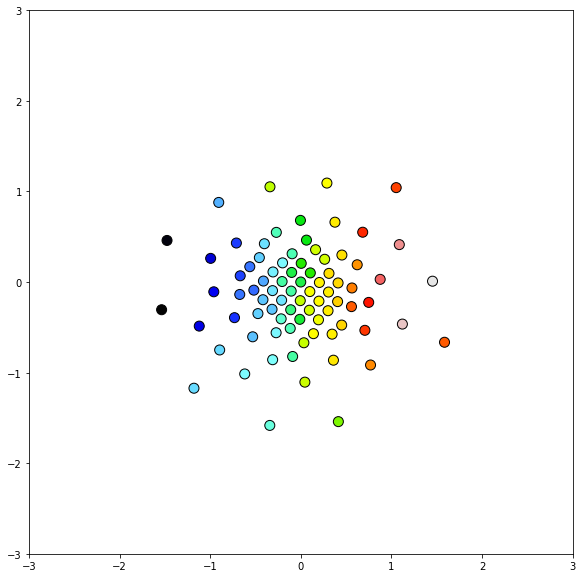

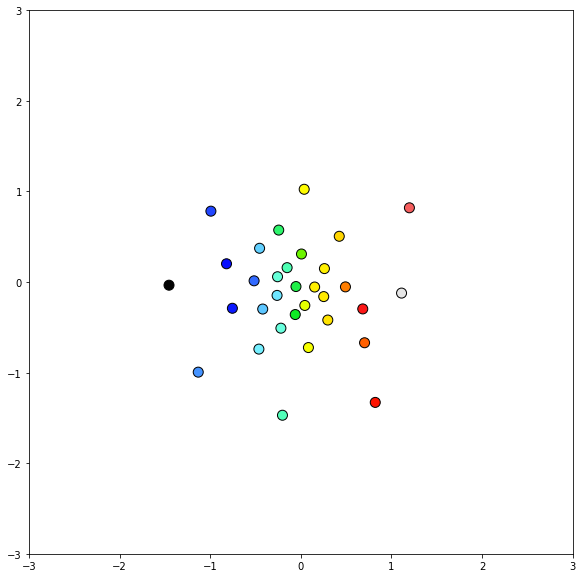

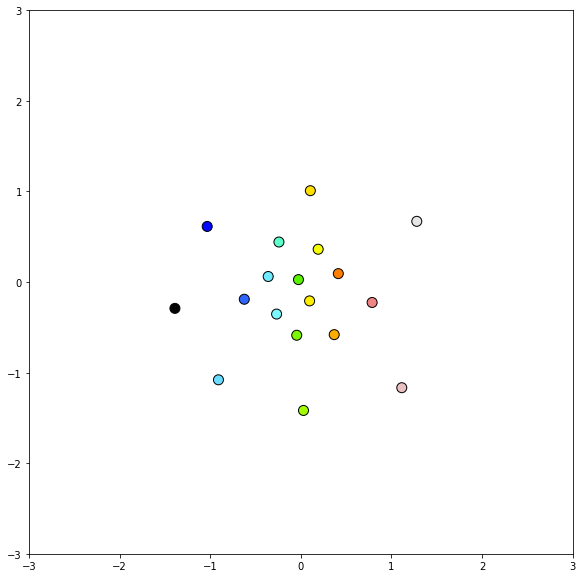

In [27]:
for SN in vorbin_SN_targets:
    target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    #target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    #Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # take the surface density, etc from mge saved parameters
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    goodbins = Vrms_bin > 50
    print('Number masked, ', len(goodbins) - len(Vrms_bin[goodbins]))
    print(Vrms_bin[goodbins])


    axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
    pa_phot = axis_info[2]


    xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)

    xbin_phot_rot, ybin_phot_rot = rotate_points(xbin_arcsec, ybin_arcsec, kcwi_pa-90-pa_phot)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(xbin_phot_rot[goodbins], ybin_phot_rot[goodbins], s=100, edgecolor='k', c=V_bin[goodbins], cmap='sauron')
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_aspect('equal')
    
    # replace values for xbinphot and ybinphot
    tommy_pickles.xbin_phot = xbin_phot_rot[goodbins]
    tommy_pickles.ybin_phot = ybin_phot_rot[goodbins]
    tommy_pickles.Vrms_bin = Vrms_bin[goodbins]
    tommy_pickles.dVrms_bind = dVrms_bin[goodbins]
    tommy_pickles.V_bin = V_bin[goodbins]
    tommy_pickles.dV_bin = dV_bin[goodbins]
    
    # dump the pickle back in
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'wb') as f:
        pickle.dump(tommy_pickles, f)